# Instruction

- Download datasets from links below and run **dataset_for_image_folder** script. It will generate folder with images splited by word for **HanwritingDataset**. That is reliable way to work with that.
- You can generate h5 dataset with augumented data for faster training and use H5Dataset. It works somewhat like this:
    - you generate dataset of size 10 (10 times original)
    - then between epochs you need to create new dataset and change **current_epoch** in H5Dataset (not implemented!)
- see examples below for understanding how it works.

# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Imports

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torch.functional import F
from torchvision import transforms, datasets
from torchvision import models
from torch.utils.data.sampler import WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skimage.morphology import skeletonize
from itertools import product

import pandas as pd
import numpy as np
import os
from PIL import Image
import copy
import cv2
import time
import shutil
import random
import h5py
from Helpers import Params, EarlyStopping, ProgressBarWithLoss, Validator, History, collate_fn, predict, train
from Datasets import HandWritingDataset, H5Dataset

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
augument = transforms.Compose([
    transforms.RandomRotation(15, expand=True, fill=(255,)),
    transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(255,)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=(255,)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x),
    transforms.Normalize((0.5,), (0.5,)),
])

# Samplers

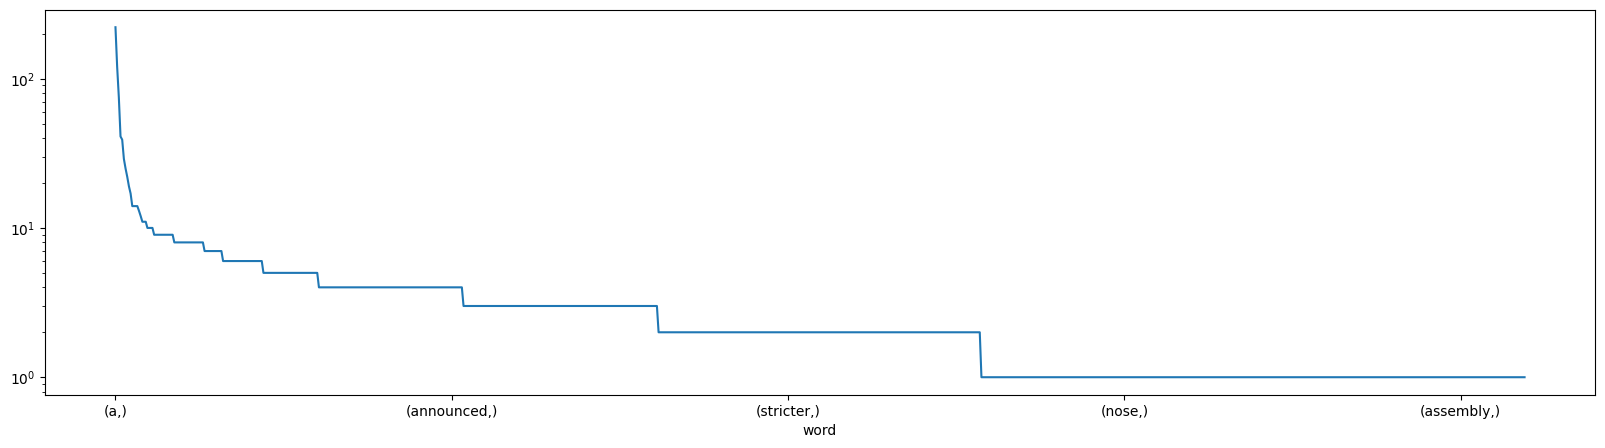

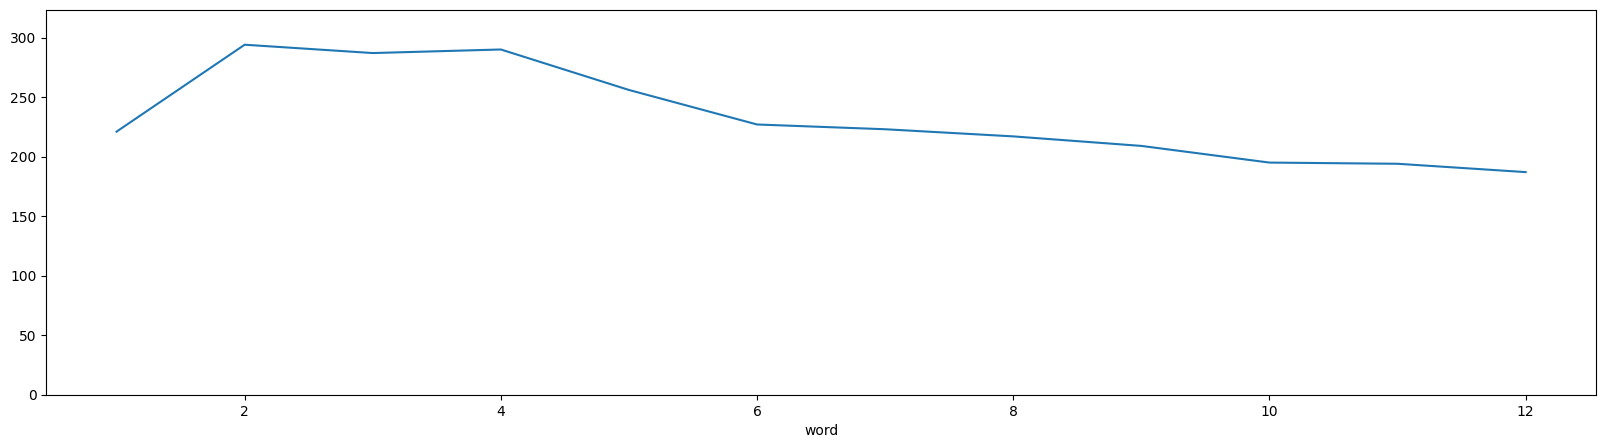

In [27]:
sampler_dataset = HandWritingDataset(root='words_data/test', transform=transform, label_transofrm=Params.encode_string)

dist_loader = DataLoader(
    sampler_dataset,
    batch_size=64,
    num_workers=4,
    sampler=sampler_dataset.create_sampler(0.001),
    collate_fn=collate_fn,
)


repeat = 1
results = []
for waiting in range(repeat):
    for i, (ims, labels) in enumerate(dist_loader):
        results.extend([Params.decode_string(i) for i in labels.tolist()])

res_df = pd.DataFrame(results, columns=['word'])

(res_df.value_counts() / repeat).plot(figsize=(20, 5), logy=True)
plt.show()

res_df = res_df['word'].apply(len).value_counts().sort_index() / repeat
res_df.plot(ylim=(0, res_df.max() * 1.1), figsize=(20, 5))
plt.show()

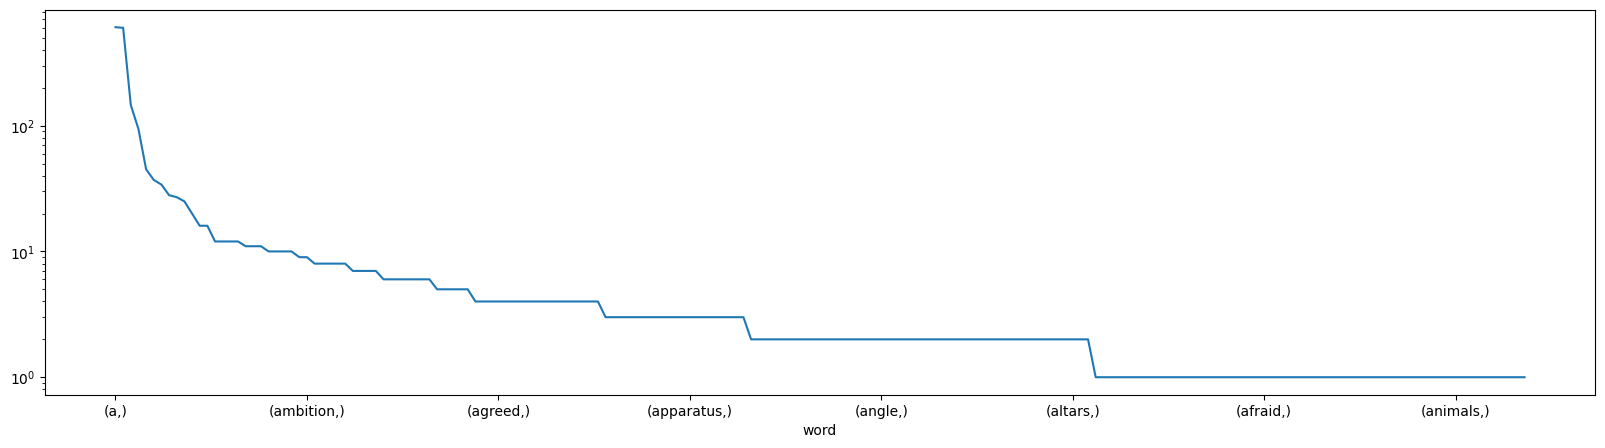

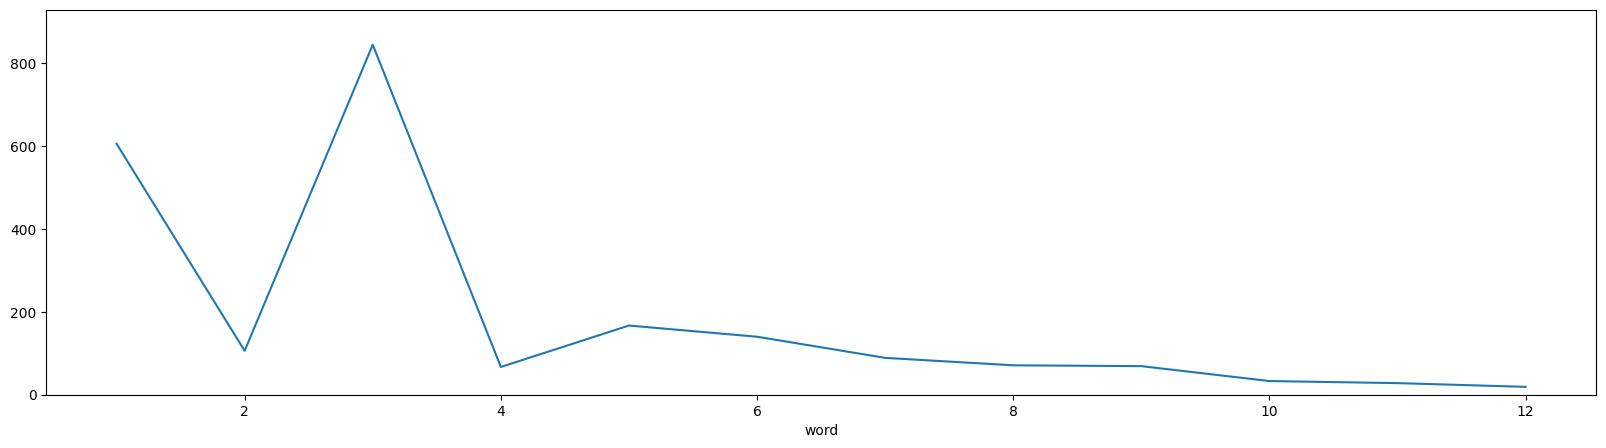

In [28]:
sampler_dataset = H5Dataset('small.h5', 20)

dist_loader = DataLoader(
    sampler_dataset,
    batch_size=32,
    num_workers=2,
    sampler=sampler_dataset.create_h5_sampler(0.1),
    collate_fn=collate_fn,
)



repeat = 1
results = []
for waiting in range(repeat):
    for i, (ims, labels) in enumerate(dist_loader):
        results.extend([Params.decode_string(i) for i in labels.tolist()])

res_df = pd.DataFrame(results, columns=['word'])

(res_df.value_counts() / repeat).plot(figsize=(20, 5), logy=True)
plt.show()

res_df = res_df['word'].apply(len).value_counts().sort_index() / repeat
res_df.plot(ylim=(0, res_df.max() * 1.1), figsize=(20, 5))
plt.show()

# Recursive Model

In [29]:
class TLModel(nn.Module):
    def __init__(self, hidden_size=512):
        super(TLModel, self).__init__()
        self.cnn = models.mobilenet_v2(pretrained=True).features[:7]

        for param in self.cnn.parameters():
            param.requires_grad = False
            
        self.gru = nn.GRU(input_size=8 * self.cnn[-1].out_channels, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True, dropout=0.5)
        
        self.dense = nn.Linear(self.gru.hidden_size * (self.gru.bidirectional + 1), 27)

    def forward(self, x):
        x = self.cnn(x)

        x = x.permute(0, 3, 2, 1)
        x = x.flatten(2)

        x, _ = self.gru(x)

        x = self.dense(x)
        x = x.permute(1, 0, 2)
        x = F.log_softmax(x, dim=2)
        
        return x

# Training H5Dataset

In [30]:
train_dataset = H5Dataset('dataset.h5', 100)
val_dataset = HandWritingDataset(root='words_data/val', transform=transform, label_transofrm=Params.encode_string)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, shuffle=True, collate_fn=collate_fn)

model = TLModel(hidden_size=1024).to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
early_stopping = EarlyStopping(patience=5)
history = History()

/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/1 [==============================] 100.00%   22.50s   Train Loss: 0.4274   Val Loss: 0.5213
Epoch 1/1 [==============================] 100.00%   21.04s   Train Loss: 0.4218   Val Loss: 0.5247


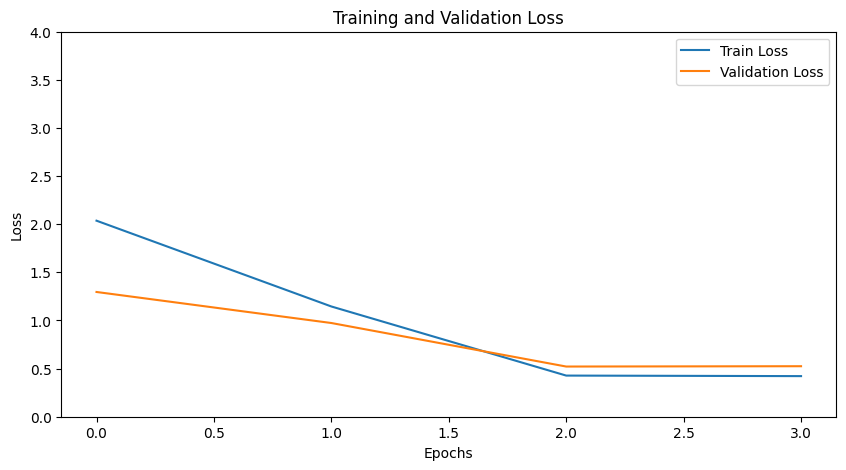

In [38]:
for i in range(2):
    train_dataset = H5Dataset('train_data.h5', 20) # I created 20 epochs of data
    train_dataset.current_epoch = i % 20 # switch to the next epoch
    train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, sampler=train_dataset.create_h5_sampler(0), collate_fn=collate_fn)
    train(model, train_loader, val_loader, optimizer, criterion, epochs=1, early_stopping=early_stopping, history=history)
history.plot()

# Training HandwritingDataset

In [32]:
train_dataset = HandWritingDataset('words_data/train', transform=transform, label_transofrm=Params.encode_string, augument=augument) # augument data
val_dataset = HandWritingDataset(root='words_data/val', transform=transform, label_transofrm=Params.encode_string)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, shuffle=True, collate_fn=collate_fn)

model = TLModel(hidden_size=1024).to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
early_stopping = EarlyStopping(patience=5)
history = History()

/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/2 [==============================] 100.00%   43.16s   Train Loss: 2.0367   Val Loss: 1.2961
Epoch 2/2 [==============================] 100.00%   46.33s   Train Loss: 1.1454   Val Loss: 0.9736


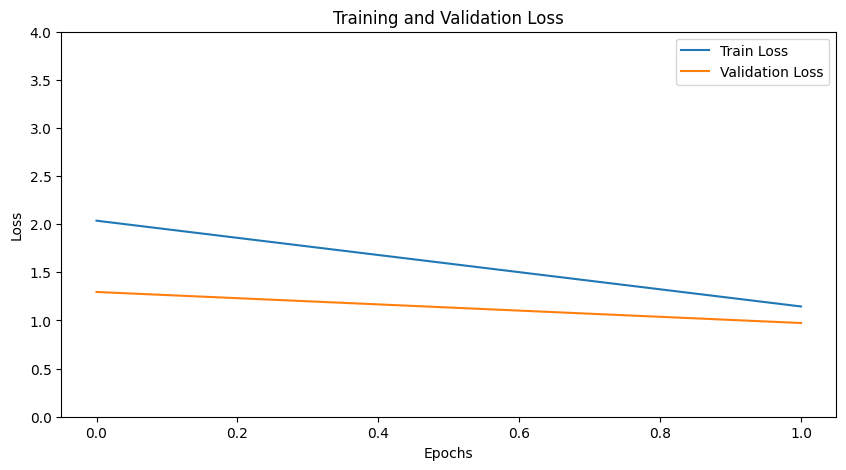

In [33]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=2, early_stopping=early_stopping, history=history)
history.plot()

# See results

In [34]:
model = TLModel(hidden_size=1024).to(device)
model.load_state_dict(torch.load('best_model200.pth'))
predict_dataset = HandWritingDataset(root='words_data/test', transform=transform, label_transofrm=Params.encode_string)
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)
predictions = predict(model, predict_loader, 100)
for pred, label in predictions:
    print(f"{pred}  -  {label}")

aannd  -  and
bbboth  -  both
uiiing  -  turning
better  -  better
thhhat  -  that
in  -  in
pppeacce  -  peace
sot  -  set
aaleady  -  already
afffilieliimens  -  affiliations
lliiiffe  -  life
tthhe  -  the
siilll  -  still
bbloos  -  blow
memaatiees  -  memories
e  -  are
on  -  on
ooof  -  of
oof  -  of
ssaay  -  say
oof  -  of
of  -  of
tto  -  to
a  -  a
sso  -  so
aaddpiestmmennt  -  adjustment
ffiiem  -  film
hauuutteerdhieg  -  handkerchief
aadbtt  -  adult
up  -  up
aat  -  at
iis  -  is
ffor  -  four
tthhe  -  the
liiberradiisnn  -  liberalism
conld  -  could
t  -  it
necesiity  -  necessity
ooff  -  of
hhhas  -  has
far  -  few
qqeoted  -  quoted
leaaders  -  leaders
because  -  because
iiin  -  in
wworrkiinng  -  working
leggatity  -  legality
math  -  main
arggees  -  argues
bby  -  by
ttthhe  -  the
tthhhe  -  the
bby  -  by
was  -  was
ttthhhe  -  the
tto  -  to
ooff  -  of
ooof  -  of
starve  -  starve
ggooord  -  good
innlellieggennt  -  intelligent
at  -  sat
been  -

# Tuning

In [35]:
# params = {
#     "hidden": [2048, 1024, 512],
#     "batch": [16, 32, 64],
#     "step": [1e-3, 1e-4],
# }
# start_time = time.time()
# results = []
# for i, (hidden, batch, step) in enumerate(product(*params.values())):
#     print(f"{i}. hidden: {hidden}, batch: {batch}, step: {step}")
#     model = TLModel(hidden_size=hidden).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=step)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
#     criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
#     train_loader = DataLoader(train_dataset, batch_size=batch, num_workers=4, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=batch, num_workers=4, shuffle=True, collate_fn=collate_fn)

#     early_stopping = EarlyStopping(patience=5)
#     history = History()

#     train(model, train_loader, val_loader, optimizer, criterion, epochs=1, early_stopping=early_stopping, history=history)
#     results.append({
#         "hidden": hidden,
#         "batch": batch,
#         "step": step,
#         "train_loss": history.history['train_loss'][-1],
#         "val_loss": history.history['val_loss'][-1],
#     })
#     scheduler.step()
#     print(f"Time elapsed: {time.time() - start_time:.2f} seconds")

# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by=['val_loss', 'train_loss'], ascending=[True, True])
# results_df.to_csv('results.csv', index=False)

In [36]:
# results_df['name'] = results_df.apply(
#     lambda x: f"{x['hidden']}   {x['batch']}   {x['step']}", axis=1)
# results_df.plot(x='name', 
#                 y=['train_loss', 'val_loss'], 
#                 kind='bar', 
#                 figsize=(18, 6), 
#                 title='Train and Validation Loss by Parameters')
# plt.ylabel('Loss')
# plt.xlabel('Parameters')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# Visual

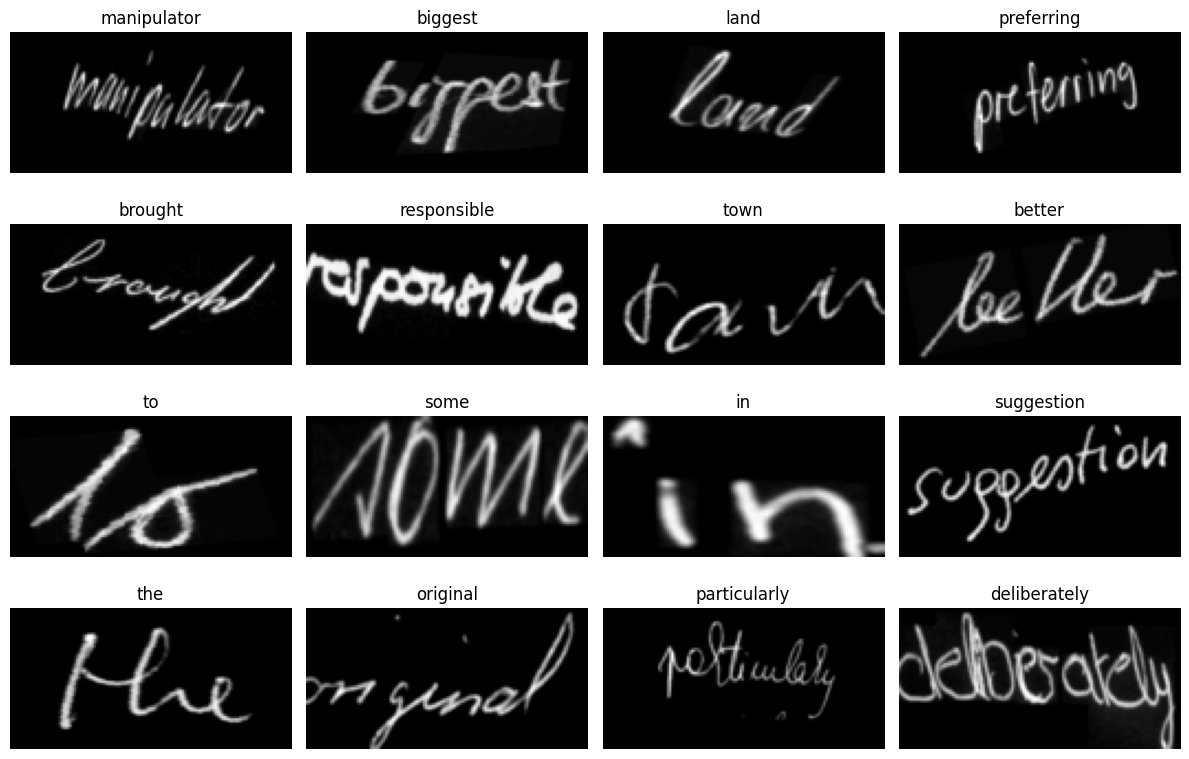

In [37]:
visual_dataset = HandWritingDataset(root='words_data/train', transform=transform, label_transofrm=Params.encode_string, augument=augument)
visual_loader = DataLoader(visual_dataset, batch_size=16, num_workers=4, sampler=visual_dataset.create_sampler(0), collate_fn=collate_fn)

images, labels = next(iter(visual_loader))

fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    if i >= len(images):
        break
    ax.imshow(images[i][0].cpu(), cmap='gray', aspect=1)
    ax.set_title(Params.decode_string(labels[i].tolist()))
    ax.axis('off')
plt.tight_layout()
plt.show()